#Imports

In [ ]:
!pip install timm

In [2]:
# !pip install torch --upgrade
# !pip install torchvision==0.12.0

In [3]:
#basic
from pathlib import Path
import random
import shutil
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
# import PIL
from PIL import Image

#modeling
from sklearn.model_selection import train_test_split
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
import timm
from torch.nn import functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ExponentialLR
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.lr_scheduler import OneCycleLR
import copy

%matplotlib inline

#Data loading

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json /root/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k

100% 1.62G/1.62G [00:25<00:00, 63.3MB/s]
100% 1.62G/1.62G [00:25<00:00, 68.2MB/s]


In [6]:
!unzip /content/ocular-disease-recognition-odir5k.zip

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  inflating: preprocessed_images/2179_left.jpg  
  inflating: preprocessed_images/2179_right.jpg  
  inflating: preprocessed_images/217_left.jpg  
  inflating: preprocessed_images/217_right.jpg  
  inflating: preprocessed_images/2180_left.jpg  
  inflating: preprocessed_images/2180_right.jpg  
  inflating: preprocessed_images/2181_left.jpg  
  inflating: preprocessed_images/2181_right.jpg  
  inflating: preprocessed_images/2182_left.jpg  
  inflating: preprocessed_images/2182_right.jpg  
  inflating: preprocessed_images/2183_left.jpg  
  inflating: preprocessed_images/2183_right.jpg  
  inflating: preprocessed_images/2184_left.jpg  
  inflating: preprocessed_images/2184_right.jpg  
  inflating: preprocessed_images/2185_left.jpg  
  inflating: preprocessed_images/2185_right.jpg  
  inflating: preprocessed_images/2187_left.jpg  
  inflating: preprocessed_images/2187_right.jpg  
  inflating: preprocessed_images/2189_left.jpg

In [7]:
df_all = pd.read_csv('/content/full_df.csv')

In [8]:
df_all.sample(5)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
5417,3106,48,Male,3106_left.jpg,3106_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",3106_left.jpg
5755,3954,58,Female,3954_left.jpg,3954_right.jpg,mild nonproliferative retinopathy,normal fundus,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",3954_left.jpg
480,550,55,Male,550_left.jpg,550_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",550_right.jpg
4110,1082,48,Male,1082_left.jpg,1082_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",1082_left.jpg
1640,2467,69,Female,2467_left.jpg,2467_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",2467_right.jpg


In [9]:
df_all[df_all['ID']==2244]

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
1505,2244,76,Male,2244_left.jpg,2244_right.jpg,lens dust，cataract,cataract，lens dust,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",2244_right.jpg


In [10]:
df_all['left_cataract'] = df_all['Left-Diagnostic Keywords'].apply(lambda x: 1 if 'cataract' in str(x).lower() else 0)
df_all['right_cataract'] = df_all['Right-Diagnostic Keywords'].apply(lambda x: 1 if 'cataract' in str(x).lower() else 0)

In [11]:
left_cataract = df_all[df_all['left_cataract'] == 1]['Left-Fundus'].values
right_cataract = df_all[df_all['right_cataract'] == 1]['Right-Fundus'].values
print(f'Number of images in left cataract: {len(left_cataract)}')
print(f'Number of images in right cataract: {len(right_cataract)}')

Number of images in left cataract: 304
Number of images in right cataract: 290


In [12]:
left_normal = df_all[(df_all['C']==0) & (df_all['Left-Diagnostic Keywords']=='normal fundus')]['Left-Fundus'].values
right_normal = df_all[(df_all['C']==0) & (df_all['Right-Diagnostic Keywords']=='normal fundus')]['Right-Fundus'].values
print(f'Number of images in left normal: {len(left_normal)}')
print(f'Number of images in right normal: {len(right_normal)}')

Number of images in left normal: 2748
Number of images in right normal: 2657


In [13]:
cataract = np.concatenate([left_cataract, right_cataract])
normal = np.concatenate([left_normal, right_normal])

In [14]:
cataract = pd.DataFrame(cataract, columns=['filename'])
normal = pd.DataFrame(normal, columns=['filename'])

In [15]:
cataract['label'] = 1
normal['label'] = 0

In [16]:
df_combined = pd.concat([cataract, normal])
df_combined.sample(10)

,filename,label
4143,215_right.jpg,0
4852,2926_right.jpg,0
2430,3232_left.jpg,0
544,2688_left.jpg,0
2331,3124_left.jpg,0
3590,2976_right.jpg,0
586,2239_right.jpg,1
2367,3166_left.jpg,0
3558,2940_right.jpg,0
5299,3427_right.jpg,0


##Data review

In [17]:
root_path = Path('/content/preprocessed_images')

In [18]:
def rand_image():
  idx = random.randint(0, len(df_combined))
  filename = df_combined.filename.iloc[idx]
  image = root_path/filename
  label = df_combined.label.iloc[idx]
  return image, label

In [19]:
# fig, axs = plt.subplots(3, 5, figsize=(15,7))
# axs = axs.flatten()

# for ax in axs:
#   img, label = rand_image()
#   img = Image.open(img)
#   ax.imshow(img)
#   ax.axis('off')
#   ax.set_title(f'Cataract: {label}')

##Sample tranformations

In [20]:
list_transforms = [transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
                                 transforms.RandomEqualize(),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.Grayscale(),
                                 transforms.RandomInvert()]

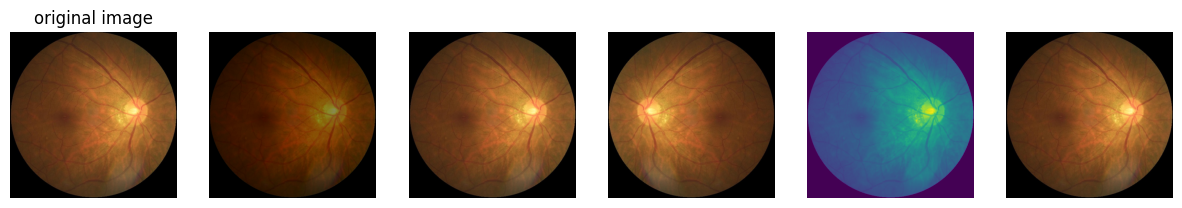

In [21]:
# fig, axs = plt.subplots(1,6, figsize=(15,3))
# axs = axs.flatten()
# img, label = rand_image()
# img = Image.open(img)


# for i, ax in enumerate(axs):
#   axs[0].imshow(img)
#   axs[0].set_title('original image')
#   transf = list_transforms[i-1]
#   ax = axs[i]
#   ax.axis('off')
#   transf_img = transf(img)
#   ax.imshow(transf_img)

#Split to train, validation and test sets

In [22]:
X = df_combined.copy()
y = df_combined['label']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=6)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=6)

In [24]:
path_dict = {'train/': X_train, 'val/': X_val, 'test/': X_test}

for key, df in path_dict.items():

  save_path = Path(key)

  for i, img in enumerate(tqdm(df.filename)):
    img_path = root_path/img

    label = df.label.iloc[i]

    img_save_path = root_path/save_path/str(label)
    img_save_path.mkdir(parents=True, exist_ok=True)

    if img_path.exists():
      shutil.copy(img_path, img_save_path)

100%|██████████| 1200/1200 [00:02<00:00, 406.03it/s]


#Create Pytorch Data Generators

In [25]:
train_path = '/content/preprocessed_images/train'
val_path = '/content/preprocessed_images/val'
test_path = '/content/preprocessed_images/test'

In [26]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Train_dataloader will be create later

val_transforms = transforms.Compose([transforms.Resize((224,224)),
                                     transforms.ToTensor(),
                                     normalize])

test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                     transforms.ToTensor(),
                                     normalize])

In [27]:
val_dataset = datasets.ImageFolder(val_path, val_transforms)
test_dataset = datasets.ImageFolder(test_path,test_transforms)

In [28]:
batch_size = 32
num_workers = 2

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [29]:
def create_dataloaders(*args, batch_size, val_loader):
  data_tranforms = transforms.Compose([*args,
                                       transforms.Resize((224, 224)),
                                       transforms.ToTensor(),
                                       normalize])

  trying_dataset = datasets.ImageFolder(train_path, data_tranforms)
  trying_loader = torch.utils.data.DataLoader(trying_dataset,
                                              batch_size = batch_size,
                                              shuffle=True,
                                              num_workers=2)

  dataloaders = {'train': trying_loader, 'val': val_loader}

  return dataloaders

#Model function

In [30]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

print(device)

cuda


In [31]:
# # Load the EfficientNet architecture
# model_b0_1 = timm.create_model('efficientnet_b0', pretrained=True)

# for param in model_b0_1.parameters():
#     param.requires_grad = False

# # Replace the last classification layer with a new layer with two outputs
# num_ftrs = model_b0_1.classifier.in_features
# model_b0_1.classifier = nn.Linear(num_ftrs, 2)

# # Add a softmax function at the end
# model_b0_1 = nn.Sequential(model_b0_1, nn.Softmax(dim=1))

# model_b0_1 = model_b0_1.to(device)

In [32]:
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model_b0_1.parameters(), lr=0.001)

In [33]:
criterion = nn.CrossEntropyLoss()

In [34]:
def prepare_model_1(pre_trained_model, class_function=nn.Sigmoid(), learning_rate=0.001):

  # Load the EfficientNet architecture
  model = timm.create_model(pre_trained_model, pretrained=True)

  for param in model.parameters():
    param.requires_grad = False

  # Replace the last classification layer with a new layer with two outputs
  num_ftrs = model.classifier.in_features
  model.classifier = nn.Linear(num_ftrs, 2)

  # Add a function at the end
  model = nn.Sequential(model, class_function)

  model = model.to(device)

  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  return model, optimizer

In [35]:
def prepare_model_2(pre_trained_model, class_function=nn.Sigmoid(), learning_rate=0.001):

  model = timm.create_model(pre_trained_model, pretrained=True)

  for param in model.parameters():
    param.requires_grad = False

  num_ftrs = model.classifier.in_features
  model.classifier = nn.Sequential(nn.Linear(num_ftrs, 256),
                                   nn.ReLU(),
                                   nn.BatchNorm1d(256),
                                   nn.Dropout(0.5),
                                   nn.Linear(256, 2))

  model = nn.Sequential(model, class_function)

  model = model.to(device)

  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  return model, optimizer

In [36]:
efficientnet_models = ['efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5']

In [37]:
# # Load the EfficientNet architecture
# efficientnet_model = timm.create_model('efficientnet_b0', pretrained=True)

# # Replace the last classification layer with a new layer with two outputs
# num_ftrs = efficientnet_model.classifier.in_features
# efficientnet_model.classifier = nn.Sequential(
#     nn.Linear(num_ftrs, 256),  # Dodaj dodatkową warstwę
#     nn.ReLU(),  # Funkcja aktywacji
#     nn.BatchNorm1d(256),  # Batch Normalization
#     nn.Dropout(0.5),  # Dropout dla regularyzacji
#     nn.Linear(256, 2)  # Warstwa klasyfikacyjna z dwoma wyjściami (2 klasy)
# )

# # Dodaj funkcję softmax na końcu
# efficientnet_model = nn.Sequential(
#     efficientnet_model,
#     nn.Softmax(dim=1)
# )

# # Wydrukuj zaktualizowaną architekturę
# print(efficientnet_model)

In [38]:
# model = models.resnet101(pretrained=True).to(device)

# for param in model.parameters():
#     param.requires_grad = False

# model.fc = nn.Sequential(
#                nn.Linear(2048, 128),
#                nn.ReLU(inplace=True),
#                nn.Linear(128, 2)).to(device)

#Train and test model function

In [39]:
def calculate_f1(precision, recall):
  F1 = 2 * precision * recall / (precision + recall)
  return F1

In [65]:
def train_model(dataloaders, model, criterion, optimizer, scheduler, num_epochs=10):

    train_loss_history = []
    train_accuracy_history = []
    val_loss_history = []
    val_accuracy_history = []
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')

        metrics = {}

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            corrects = 0
            r_positives = 0
            t_positives = 0
            tf_positives = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                  optimizer.zero_grad()
                  loss.backward()
                  optimizer.step()
                  # scheduler.step()


                metrics[phase] = {}
                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                corrects += sum(preds == labels.data)
                r_positives += sum(labels == 1).item()
                t_positives += sum((preds == labels) & (labels == 1)).item()
                tf_positives += sum(preds == 1).item()

            num_inputs = len(dataloaders[phase].dataset)
            metrics[phase]['loss'] = round(running_loss / num_inputs, 4)
            metrics[phase]['acc'] = round(corrects.item() / num_inputs, 4)
            metrics[phase]['precision'] = round(t_positives / tf_positives, 4)
            metrics[phase]['recall'] = round(t_positives / r_positives, 4)
            metrics[phase]['F1'] = round(calculate_f1(metrics[phase]['precision'], metrics[phase]['recall']), 4)

            print(f'{phase} loss: {metrics[phase]["loss"]:.4f}, {phase} accuracy: {metrics[phase]["acc"]:.4f}')

        if metrics['val']['loss'] <= best_val_loss:
            best_val_loss = metrics['val']['loss']
            best_metrics = pd.DataFrame(metrics)
            best_model = model

        train_loss_history.append(metrics['train']['loss'])
        train_accuracy_history.append(metrics['train']['acc'])
        val_loss_history.append(metrics['val']['loss'])
        val_accuracy_history.append(metrics['val']['acc'])

        train_history = [train_accuracy_history, val_accuracy_history, train_loss_history, val_loss_history]

        if phase == 'train':
            scheduler.step()

    return best_model, best_metrics, train_history

In [41]:
# train_loss_history = []
# train_accuracy_history = []
# val_loss_history = []
# val_accuracy_history = []
# best_train_accuracy = 0
# best_val_accuracy = 0

# for epoch in range(num_epochs):
#     print(f'Epoch {epoch+1}/{num_epochs}')

#     metrics = {}

#     for phase in ['train', 'val']:
#         if phase == 'train':
#             model.train()
#         else:
#             model.eval()

#         running_loss = 0.0
#         corrects = 0
#         r_positives = 0
#         t_positives = 0
#         tf_positives = 0

#         for inputs, labels in dataloaders[phase]:
#             inputs = inputs.to(device)
#             labels = labels.to(device)

#             outputs = model(inputs)
#             loss = criterion(outputs, labels)

#             if phase == 'train':
#                 optimizer.zero_grad()
#                 loss.backward()
#                 optimizer.step()

#             metrics[phase] = {}
#             _, preds = torch.max(outputs, 1)
#             running_loss += loss.item() * inputs.size(0)
#             corrects += sum(preds == labels.data).item()
#             r_positives += sum(labels == 1).item()
#             t_positives += sum((preds == labels) & (labels == 1)).item()
#             tf_positives += sum(preds == 1).item()

#         num_inputs = len(dataloaders[phase].dataset)
#         metrics[phase]['loss'] = round(running_loss / num_inputs, 4)
#         metrics[phase]['acc'] = round(corrects / num_inputs, 4)
#         metrics[phase]['precision'] = round(t_positives / tf_positives, 4)
#         metrics[phase]['recall'] = round(t_positives / r_positives, 4)
#         metrics[phase]['F1'] = round(calculate_f1(metrics[phase]['precision'], metrics[phase]['recall']), 4)


#         print(f'{phase} loss: {metrics[phase]["loss"]:.4f}, {phase} accuracy: {metrics[phase]["acc"]:.4f}')

#     if (metrics['val']['acc'] >= best_val_accuracy): # and (metrics['train']['acc'] >= best_train_accuracy):
#       best_val_accuracy = metrics['val']['acc']
#       best_train_accuracy = metrics['train']['acc']
#       best_metrics = pd.DataFrame(metrics)
#       best_model = model

#     train_loss_history.append(metrics['train']['loss'])
#     train_accuracy_history.append(metrics['train']['acc'])
#     val_loss_history.append(metrics['val']['loss'])
#     val_accuracy_history.append(metrics['val']['acc'])

#     train_history = [train_accuracy_history, val_accuracy_history, train_loss_history, val_loss_history]

In [42]:
# if val_roc >= best_val:
#                 best_val = val_roc
#                 patience = es_patience  # Resetting patience since we have new best validation accuracy
#                 torch.save(model, model_path)  # Saving current best model
#             else:
#                 patience -= 1
#                 if patience == 0:
#                     print('Early stopping. Best Val roc_auc: {:.3f}'.format(best_val))
#                     break

In [43]:
# num_epochs = 10
# model = model_b0_1
# dataloaders = {'train': train_loader, 'val': val_loader}

In [44]:
def test_model(dataloader, model, criterion):

  running_loss = 0.0
  running_corrects = 0

  model.eval()

  for inputs, labels in dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    loss = criterion(outputs, labels)

    _, preds = torch.max(outputs, 1)
    running_loss += loss.item() * inputs.size(0)
    running_corrects += sum(preds == labels.data)

    num_inputs = len(dataloader.dataset)
    test_loss = running_loss / num_inputs
    test_accuracy = running_corrects.item() / num_inputs

  return test_loss, test_accuracy

In [45]:
def plot_learning(train_history):
  fig, axs = plt.subplots(1, 2, figsize=(15, 5))
  history = {'Accuracy': [train_history[0], train_history[1]], 'Loss': [train_history[2], train_history[3]]}

  for i, name in enumerate(['Accuracy', 'Loss']):
    ax = axs[i]
    ax.plot(history[name][0], label='train')
    ax.plot(history[name][1], label='validation')
    ax.set_title(name)
    ax.legend()
    ax.set_xlabel('no. of epochs')
  plt.show()

In [ ]:
# plot_learning(train_history)

In [ ]:
# plot_learning(train_history)

#Selecting

In [47]:
batch_size = 64

In [48]:
dataloaders = create_dataloaders(batch_size=64, val_loader=val_loader)

##Selecting model type

In [91]:
model_1, optimizer_1 = prepare_model_1('efficientnet_b0')
model_2, optimizer_2 = prepare_model_2('efficientnet_b0')

In [92]:
models = {'model_1': [model_1, optimizer_1], 'model_2': [model_2, optimizer_2]}

In [93]:
i = 0
model_scores = pd.DataFrame({'models': models.keys(),
                             'loss': np.zeros(len(models)),
                             'accuracy': np.zeros(len(models)),
                             'precision': np.zeros(len(models)),
                             'recall': np.zeros(len(models)),
                             'F1': np.zeros(len(models))})

for key, option in models.items():
  print(key)
  model = option[0]
  optimizer = option[1]
  scheduler = StepLR(optimizer, step_size=10, gamma=1)
  trained_model, metrics, history = train_model(dataloaders, model, criterion, optimizer, scheduler, num_epochs=20)
  print()

  for j in list(range(1,6)):
    model_scores.iloc[i,j] = metrics.iloc[j-1,1]

  i+=1

model_1
Epoch 1/20
train loss: 0.4528, train accuracy: 0.8876
val loss: 0.3897, val accuracy: 0.9265
Epoch 2/20
train loss: 0.3818, train accuracy: 0.9409
val loss: 0.3683, val accuracy: 0.9656
Epoch 3/20
train loss: 0.3669, train accuracy: 0.9593
val loss: 0.3597, val accuracy: 0.9665
Epoch 4/20
train loss: 0.3593, train accuracy: 0.9640
val loss: 0.3547, val accuracy: 0.9684
Epoch 5/20
train loss: 0.3547, train accuracy: 0.9675
val loss: 0.3503, val accuracy: 0.9712
Epoch 6/20
train loss: 0.3523, train accuracy: 0.9652
val loss: 0.3490, val accuracy: 0.9721
Epoch 7/20
train loss: 0.3492, train accuracy: 0.9675
val loss: 0.3478, val accuracy: 0.9721
Epoch 8/20
train loss: 0.3468, train accuracy: 0.9714
val loss: 0.3459, val accuracy: 0.9730
Epoch 9/20
train loss: 0.3473, train accuracy: 0.9710
val loss: 0.3455, val accuracy: 0.9730
Epoch 10/20
train loss: 0.3457, train accuracy: 0.9714
val loss: 0.3451, val accuracy: 0.9721
Epoch 11/20
train loss: 0.3449, train accuracy: 0.9718
val lo

In [94]:
#Scores for validation set
model_scores

,models,loss,accuracy,precision,recall,F1
0,model_1,0.3391,0.9758,0.8969,0.8447,0.8700
1,model_2,0.3234,0.9898,0.9600,0.9320,0.9458


##Selecting class_function

In [49]:
model_si, optimizer_si = prepare_model_2('efficientnet_b0', nn.Sigmoid())
model_sf, optimizer_sf = prepare_model_2('efficientnet_b0', nn.Softmax(dim=1))

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [50]:
class_functions = {'Sigmoid': [model_si, optimizer_si], 'Softmax': [model_sf, optimizer_sf]}

In [51]:
i = 0
class_scores = pd.DataFrame({'models': class_functions.keys(),
                             'loss': np.zeros(len(class_functions)),
                             'accuracy': np.zeros(len(class_functions)),
                             'precision': np.zeros(len(class_functions)),
                             'recall': np.zeros(len(class_functions)),
                             'F1': np.zeros(len(class_functions))})

for key, option in class_functions.items():
  print(key)
  model = option[0]
  optimizer = option[1]
  scheduler = StepLR(optimizer, step_size=10, gamma=1)
  trained_model, metrics, history = train_model(dataloaders, model, criterion, optimizer, scheduler, num_epochs=10)
  print()

  for j in list(range(1,6)):
    class_scores.iloc[i,j] = metrics.iloc[j-1,1]

  i+=1

Sigmoid
Epoch 1/10
train loss: 0.5004, train accuracy: 0.8602
val loss: 0.4036, val accuracy: 0.9479
Epoch 2/10
train loss: 0.3865, train accuracy: 0.9522
val loss: 0.3595, val accuracy: 0.9665
Epoch 3/10
train loss: 0.3573, train accuracy: 0.9667
val loss: 0.3435, val accuracy: 0.9767
Epoch 4/10
train loss: 0.3463, train accuracy: 0.9745
val loss: 0.3391, val accuracy: 0.9786
Epoch 5/10
train loss: 0.3415, train accuracy: 0.9773
val loss: 0.3353, val accuracy: 0.9833
Epoch 6/10
train loss: 0.3369, train accuracy: 0.9792
val loss: 0.3338, val accuracy: 0.9842
Epoch 7/10
train loss: 0.3379, train accuracy: 0.9777
val loss: 0.3311, val accuracy: 0.9833
Epoch 8/10
train loss: 0.3316, train accuracy: 0.9839
val loss: 0.3305, val accuracy: 0.9842
Epoch 9/10
train loss: 0.3362, train accuracy: 0.9781
val loss: 0.3301, val accuracy: 0.9851
Epoch 10/10
train loss: 0.3349, train accuracy: 0.9812
val loss: 0.3257, val accuracy: 0.9888

Softmax
Epoch 1/10
train loss: 0.4716, train accuracy: 0.860

In [112]:
#Scores for validation set
class_scores

,models,loss,accuracy,precision,recall,F1
0,Sigmoid,0.3254,0.9888,0.9505,0.932,0.9412
1,Softmax,0.3243,0.9898,0.9600,0.932,0.9458


In [52]:
print('Scores for validation set')
class_scores

Scores for validation set


,models,loss,accuracy,precision,recall,F1
0,Sigmoid,0.3257,0.9888,0.9596,0.9223,0.9406
1,Softmax,0.3254,0.9879,0.9500,0.9223,0.9359


##Selecting transformations

In [55]:
model, optimizer = model_sf, optimizer_sf
scheduler = StepLR(optimizer_sf, step_size=10, gamma=1)

In [54]:
transformations = {'ColorJitter': transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
                   'RandomSharpness_08': transforms.RandomAdjustSharpness(sharpness_factor=0.8),
                   'RandomEqualize': transforms.RandomEqualize(),
                   'GaussianBlur_1': transforms.GaussianBlur(kernel_size=(3,3), sigma=(0.5,2)),
                   'RandomHorizontalFlip': transforms.RandomHorizontalFlip(),
                   'RandomAffine': transforms.RandomAffine(degrees=(-5,5), translate=(0, 0.05), scale=(0.95, 1.05)),
                   'RandomSharpness_11': transforms.RandomAdjustSharpness(sharpness_factor=1.1),
                   'RandomInvert': transforms.RandomInvert(),
                   'RandomAutocontrast': transforms.RandomAutocontrast(),
                   'RandomGrayscale': transforms.RandomGrayscale(p=0.5),
                   'GaussianBlur_2': transforms.GaussianBlur(kernel_size=(5,5), sigma=(0.1,1)),
                   'RandomVerticalFlip': transforms.RandomVerticalFlip(),
                   'RandomRotation': transforms.RandomRotation(degrees=(-5, 5)),
                   'RandomCrop': transforms.RandomCrop(size=(200, 200)),
                   'RandomSharpness_12': transforms.RandomAdjustSharpness(sharpness_factor=1.2)}

In [56]:
i = 0
transformations_scores = pd.DataFrame({'transformations': transformations.keys(),
                                       'loss': np.zeros(len(transformations)),
                                       'accuracy': np.zeros(len(transformations)),
                                       'precision': np.zeros(len(transformations)),
                                       'recall': np.zeros(len(transformations)),
                                       'F1': np.zeros(len(transformations))})

for key, transform in transformations.items():
  print(key)
  dataloaders = create_dataloaders(transform, batch_size=64, val_loader=val_loader)
  trained_model, metrics, history = train_model(dataloaders, model, criterion, optimizer, scheduler, num_epochs=5)
  print()

  for j in list(range(1,6)):
    transformations_scores.iloc[i,j] = metrics.iloc[j-1,1]

  i+=1

ColorJitter
Epoch 1/5
train loss: 0.3372, train accuracy: 0.9757
val loss: 0.3272, val accuracy: 0.9860
Epoch 2/5
train loss: 0.3386, train accuracy: 0.9753
val loss: 0.3279, val accuracy: 0.9851
Epoch 3/5
train loss: 0.3389, train accuracy: 0.9738
val loss: 0.3280, val accuracy: 0.9851
Epoch 4/5
train loss: 0.3337, train accuracy: 0.9812
val loss: 0.3279, val accuracy: 0.9860
Epoch 5/5
train loss: 0.3348, train accuracy: 0.9789
val loss: 0.3281, val accuracy: 0.9851

RandomSharpness_08
Epoch 1/5
train loss: 0.3261, train accuracy: 0.9883
val loss: 0.3261, val accuracy: 0.9870
Epoch 2/5
train loss: 0.3244, train accuracy: 0.9906
val loss: 0.3261, val accuracy: 0.9860
Epoch 3/5
train loss: 0.3275, train accuracy: 0.9863
val loss: 0.3249, val accuracy: 0.9888
Epoch 4/5
train loss: 0.3266, train accuracy: 0.9867
val loss: 0.3254, val accuracy: 0.9870
Epoch 5/5
train loss: 0.3261, train accuracy: 0.9879
val loss: 0.3253, val accuracy: 0.9879

RandomEqualize
Epoch 1/5
train loss: 0.3410, tr

In [57]:
#Scores for validation set
transformations_scores

,transformations,loss,accuracy,precision,recall,F1
0,ColorJitter,0.3272,0.9860,0.9400,0.9126,0.9261
1,RandomSharpness_08,0.3249,0.9888,0.9596,0.9223,0.9406
2,RandomEqualize,0.3284,0.9842,0.9479,0.8835,0.9146
3,GaussianBlur_1,0.3240,0.9907,0.9697,0.9320,0.9505
4,RandomHorizontalFlip,0.3225,0.9907,0.9515,0.9515,0.9515
5,RandomAffine,0.3236,0.9898,0.9510,0.9417,0.9463
6,RandomSharpness_11,0.3221,0.9916,0.9700,0.9417,0.9556
7,RandomInvert,0.3287,0.9851,0.9307,0.9126,0.9216
8,RandomAutocontrast,0.3234,0.9898,0.9600,0.9320,0.9458
9,RandomGrayscale,0.3284,0.9833,0.9293,0.8932,0.9109


In [60]:
selected_transforms = transforms.RandomChoice([transforms.RandomHorizontalFlip(),
                                               transforms.RandomAffine(degrees=(-5,5), translate=(0, 0.05), scale=(0.95, 1.05)),
                                               transforms.RandomAdjustSharpness(sharpness_factor=1.1),
                                               transforms.RandomInvert(),
                                               transforms.RandomAutocontrast(),
                                               transforms.GaussianBlur(kernel_size=(5,5), sigma=(0.1,1)),
                                               transforms.RandomVerticalFlip(),
                                               transforms.RandomRotation(degrees=(-5, 5)),
                                               transforms.RandomAdjustSharpness(sharpness_factor=1.2)])

In [ ]:
valid_scores

,transformations,accuracy,precision,recall,F1
0,ColorJitter,0.9786,0.9082,0.8641,0.8856
1,RandomEqualize,0.9842,0.9574,0.8738,0.9137
2,RandomInvert,0.9842,0.9479,0.8835,0.9146
3,RandomAutocontrast,0.9860,0.9583,0.8932,0.9246
4,RandomGrayscale,0.9823,0.9286,0.8835,0.9055
5,RandomHorizontalFlip,0.9888,0.9505,0.9320,0.9412
6,RandomRotation,0.9879,0.9500,0.9223,0.9359
7,RandomCrop,0.9563,0.7545,0.8058,0.7793


In [ ]:
valid_scores

,transformations,accuracy,precision,recall,F1
0,ColorJitter,0.9740,0.9121,0.8058,0.8557
1,RandomEqualize,0.9758,0.8812,0.8641,0.8726
2,RandomAffine,0.9767,0.8824,0.8738,0.8781
3,RandomInvert,0.9767,0.8679,0.8932,0.8804
4,RandomAutocontrast,0.9814,0.9192,0.8835,0.9010
5,RandomGrayscale,0.9767,0.8900,0.8641,0.8769
6,RandomHorizontalFlip,0.9814,0.9109,0.8932,0.9020
7,RandomVerticalFlip,0.9870,0.9684,0.8932,0.9293
8,RandomRotation,0.9898,0.9600,0.9320,0.9458
9,RandomCrop,0.9498,0.6842,0.8835,0.7712


## Selecting train batch size

In [58]:
batch_size_list = [2, 4, 16, 32, 64, 128]

In [63]:
batch_scores = pd.DataFrame({'batch_size': batch_size_list,
                             'loss': np.zeros(len(batch_size_list)),
                             'accuracy': np.zeros(len(batch_size_list)),
                             'precision': np.zeros(len(batch_size_list)),
                             'recall': np.zeros(len(batch_size_list)),
                             'F1': np.zeros(len(batch_size_list))})

for i, batch_size in enumerate(batch_size_list):
  print(f'Batch_size: {batch_size}')
  dataloaders = create_dataloaders(selected_transforms, batch_size=batch_size, val_loader=val_loader)
  trained_model, metrics, history = train_model(dataloaders, model, criterion, optimizer, scheduler, num_epochs=10)
  print()

  for j in list(range(1,6)):
    batch_scores.iloc[i,j] = metrics.iloc[j-1,1]

Batch_size: 2
Epoch 1/10
train loss: 0.3908, train accuracy: 0.9186
val loss: 0.5494, val accuracy: 0.7619
Epoch 2/10
train loss: 0.3788, train accuracy: 0.9327
val loss: 0.6863, val accuracy: 0.6270
Epoch 3/10
train loss: 0.3760, train accuracy: 0.9362
val loss: 0.6496, val accuracy: 0.6614
Epoch 4/10
train loss: 0.3775, train accuracy: 0.9342
val loss: 0.5395, val accuracy: 0.7730
Epoch 5/10
train loss: 0.3742, train accuracy: 0.9366
val loss: 0.5942, val accuracy: 0.7163
Epoch 6/10
train loss: 0.3699, train accuracy: 0.9428
val loss: 0.6063, val accuracy: 0.7060
Epoch 7/10
train loss: 0.3640, train accuracy: 0.9471
val loss: 0.6230, val accuracy: 0.6902
Epoch 8/10
train loss: 0.3637, train accuracy: 0.9491
val loss: 0.6400, val accuracy: 0.6716
Epoch 9/10
train loss: 0.3620, train accuracy: 0.9487
val loss: 0.5857, val accuracy: 0.7265
Epoch 10/10
train loss: 0.3722, train accuracy: 0.9393
val loss: 0.5490, val accuracy: 0.7628

Batch_size: 4
Epoch 1/10
train loss: 0.3572, train acc

In [ ]:
#Scores for validation set
batch_scores

,batch_size,loss,accuracy,precision,recall,F1
0,2,0.4607,0.8409,0.3731,0.9709,0.5391
1,4,0.3591,0.9544,0.6875,0.9612,0.8016
2,16,0.3320,0.9823,0.8818,0.9417,0.9108
3,32,0.3274,0.9870,0.9159,0.9515,0.9334
4,64,0.3258,0.9888,0.9417,0.9417,0.9417
5,128,0.3252,0.9879,0.9327,0.9417,0.9372


In [64]:
#Scores for validation set
batch_scores

,batch_size,loss,accuracy,precision,recall,F1
0,2,0.5395,0.7730,0.2945,0.9806,0.4530
1,4,0.3895,0.9247,0.5640,0.9417,0.7055
2,16,0.3320,0.9805,0.9362,0.8544,0.8934
3,32,0.3236,0.9898,0.9600,0.9320,0.9458
4,64,0.3236,0.9898,0.9600,0.9320,0.9458
5,128,0.3238,0.9898,0.9600,0.9320,0.9458


In [77]:
batch_size = 64

##Selecting learning rate sheduler

In [81]:
num_epochs = 20
total_steps = len(dataloaders['train'])*num_epochs

In [87]:
st_scheduler = StepLR(optimizer, step_size=10, gamma=1)

exp_scheduler = ExponentialLR(optimizer, gamma=0.7)

cos_scheduler = CosineAnnealingLR(optimizer, T_max=total_steps, eta_min=0.0001)

oc_cos_scheduler = OneCycleLR(optimizer, max_lr=0.001,
                              total_steps=total_steps,
                              epochs=num_epochs,
                              anneal_strategy='cos')

oc_lin_scheduler = OneCycleLR(optimizer,
                              max_lr=0.001,
                              total_steps=total_steps,
                              epochs=num_epochs,
                              anneal_strategy="linear")

In [91]:
schedulers = {'st_scheduler': st_scheduler,
              'exp_scheduler': exp_scheduler,
              'cos_scheduler': cos_scheduler,
              'oc_cos_scheduler': oc_cos_scheduler,
              'oc_lin_scheduler': oc_lin_scheduler}

In [93]:
dataloaders = create_dataloaders(selected_transforms, batch_size=batch_size, val_loader=val_loader)

scheduler_scores = pd.DataFrame({'scheduler': schedulers.keys(),
                             'loss': np.zeros(len(schedulers)),
                             'accuracy': np.zeros(len(schedulers)),
                             'precision': np.zeros(len(schedulers)),
                             'recall': np.zeros(len(schedulers)),
                             'F1': np.zeros(len(schedulers))})

i=0
for key, scheduler in schedulers.items():
  print(f'scheduler: {key}')
  model, optimizer = prepare_model_2('efficientnet_b0', class_function=nn.Softmax(dim=1), learning_rate=0.001)
  trained_model, metrics, history = train_model(dataloaders, model, criterion, optimizer, scheduler, num_epochs=num_epochs)
  print()

  for j in list(range(1,6)):
    scheduler_scores.iloc[i,j] = metrics.iloc[j-1,1]

  i+=1

scheduler: st_scheduler
Epoch 1/5
train loss: 0.3261, train accuracy: 0.9871
val loss: 0.3245, val accuracy: 0.9879
Epoch 2/5
train loss: 0.3279, train accuracy: 0.9851
val loss: 0.3246, val accuracy: 0.9888
Epoch 3/5
train loss: 0.3293, train accuracy: 0.9832
val loss: 0.3251, val accuracy: 0.9879
Epoch 4/5
train loss: 0.3302, train accuracy: 0.9824
val loss: 0.3246, val accuracy: 0.9879
Epoch 5/5
train loss: 0.3258, train accuracy: 0.9875
val loss: 0.3252, val accuracy: 0.9879

scheduler: exp_scheduler
Epoch 1/5
train loss: 0.3281, train accuracy: 0.9855
val loss: 0.3245, val accuracy: 0.9888
Epoch 2/5
train loss: 0.3283, train accuracy: 0.9847
val loss: 0.3245, val accuracy: 0.9879
Epoch 3/5
train loss: 0.3249, train accuracy: 0.9886
val loss: 0.3251, val accuracy: 0.9879
Epoch 4/5
train loss: 0.3290, train accuracy: 0.9839
val loss: 0.3246, val accuracy: 0.9888
Epoch 5/5
train loss: 0.3261, train accuracy: 0.9867
val loss: 0.3249, val accuracy: 0.9879

scheduler: cos_scheduler
Epoc

In [94]:
scheduler_scores

,scheduler,loss,accuracy,precision,recall,F1
0,st_scheduler,0.3245,0.9879,0.9500,0.9223,0.9359
1,exp_scheduler,0.3245,0.9879,0.9500,0.9223,0.9359
2,cos_scheduler,0.3243,0.9888,0.9505,0.9320,0.9412
3,oc_cos_scheduler,0.3244,0.9888,0.9596,0.9223,0.9406
4,oc_lin_scheduler,0.3216,0.9916,0.9608,0.9515,0.9561


##Training model

###Few_transformations

In [ ]:
few_transformations = [transforms.RandomInvert(),
                       transforms.RandomAutocontrast(),
                       transforms.RandomEqualize()]

In [ ]:
dataloaders_few = create_dataloaders(*few_transformations)

In [ ]:
model_trained_few, metrics_few, history_few = train_model(dataloaders_few,
                                                          model,
                                                          criterion,
                                                          optimizer,
                                                          num_epochs=600)

plot_learning(history_few)

print(f'\n The best results for few_transformations:')
metrics_few

In [ ]:
torch.save(model_trained_few.state_dict(),'/content/drive/MyDrive/Models/Alien_vs_Predator/best_model_few.pt')

##Evaluate

In [ ]:
outcomes = pd.concat([metrics_few, metrics_ri, metrics_ra, metrics_re, metrics_taw, metrics_aa],
                     keys=['few_transformation', 'RI_transformation', 'RA_transformation', 'RE_transformation', 'TAW_transformation', 'AutoA_transformation'])
outcomes

train     val
few_transformation   loss  0.0382  0.0675
                     acc   0.9918  0.9856
RI_transformation    loss  0.0170  0.0986
                     acc   0.9979  0.9712
RA_transformation    loss  0.0151  0.1577
                     acc   1.0000  0.9615
RE_transformation    loss  0.0121  0.1348
                     acc   0.9959  0.9663
TAW_transformation   loss  0.0351  0.1554
                     acc   0.9877  0.9615
AutoA_transformation loss  0.1142  0.1186
                     acc   0.9630  0.9663

In [ ]:
import torch
import torch.nn.functional as F

class CNN1(torch.nn.Module):
    # Zdefiniuj model CNN1

class CNN2(torch.nn.Module):
    # Zdefiniuj model CNN2

# ... Definiuj modele dla CNN3, CNN4, CNN5

def predict_proba_ensemble(models, data):
    probabilities = []
    for model in models:
        output = model(data)
        probabilities.append(F.softmax(output, dim=1))

    # Uśrednianie prawdopodobieństw
    probabilities = torch.stack(probabilities)
    averaged_probabilities = torch.mean(probabilities, dim=0)

    return averaged_probabilities

# Utwórz listę modeli
models = [CNN1(), CNN2(), CNN3(), CNN4(), CNN5()]

# Wprowadź dane testowe (zmień to zgodnie z potrzebami)
input_data = torch.randn(1, 3, 64, 64)

# Uzyskaj uśrednione prawdopodobieństwa
ensemble_probabilities = predict_proba_ensemble(models, input_data)

##Loading model

##Prediction

In [ ]:
dataloaders = dataloaders_few
best_model = model
best_model.load_state_dict(torch.load('/content/drive/MyDrive/Models/Alien_vs_Predator/best_model_few.pt'))
loss, accuracy = test_model(dataloaders['test'], best_model, criterion)
print(f'Accuracy for test dataset: {accuracy:.4f}')
print(f'Loss for test dataset: {loss:.4f}')

Accuracy for test dataset: 0.9400
Loss for test dataset: 0.1772


###Sample preditions

In [ ]:
data_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(), normalize])

In [ ]:
img_label_list = [rand_image('test') for i in range(4)]
img_list = [img_label_list[i][0] for i in range(4)]
label_list = [img_label_list[i][1] for i in range(4)]

In [ ]:
test_batch = torch.stack([data_transforms(img).to(device) for img in img_list])

pred_logits_tensor = best_model(test_batch)
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()*100

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(15, 6))

for i, img in enumerate(img_list):
  ax = axs[i]
  ax.axis('off')
  ax.set_title(f'{label_list[i]} \n alien: {pred_probs[i,0]:.0f}%, predator: {pred_probs[i,1]:.0f}%')
  ax.imshow(img)